In [ ]:
!pip install opencv-python

In [ ]:
!pip install numpy

In [ ]:
!pip install ultralytics

In [1]:
from pathlib import Path
from ultralytics import YOLO
import matplotlib.pyplot as plt 
import cv2
import json

In [4]:

# Definição do caminho para a imagem e qual modelo será utilizado
CAMINHO_IMAGEM = Path("Imagens/2013-04-10_15_20_10.jpg")
MODELO_YOLO = "runs/detect/train/weights/best.pt"
#MODELO_YOLO = "yolov8n.pt"

# Possiveis modelos: yolov8m.pt  yolov8n.pt  yolov8s.pt

# Define o caminho de saída da imagem com as vagas
pasta_saida = Path("Saida/Imagens")
pasta_saida.mkdir(parents=True, exist_ok=True)

# Define um caminho de saída para o JSON de vagas
pasta_saida_JSON = Path("Saida/Vagas")
pasta_saida_JSON.mkdir(parents=True, exist_ok=True)
CAMINHO_VAGAS_JSON = pasta_saida_JSON / f"{CAMINHO_IMAGEM.stem}.JSON"

print(f"Usando imagem: {CAMINHO_IMAGEM}")
print(f"Salvando vagas em: {CAMINHO_VAGAS_JSON}")

Usando imagem: Imagens\2013-04-10_15_20_10.jpg
Salvando vagas em: Saida\Vagas\2013-04-10_15_20_10.JSON


Carregando modelo runs/detect/train/weights/best.pt...
Processando 2013-04-10_15_20_10.jpg...


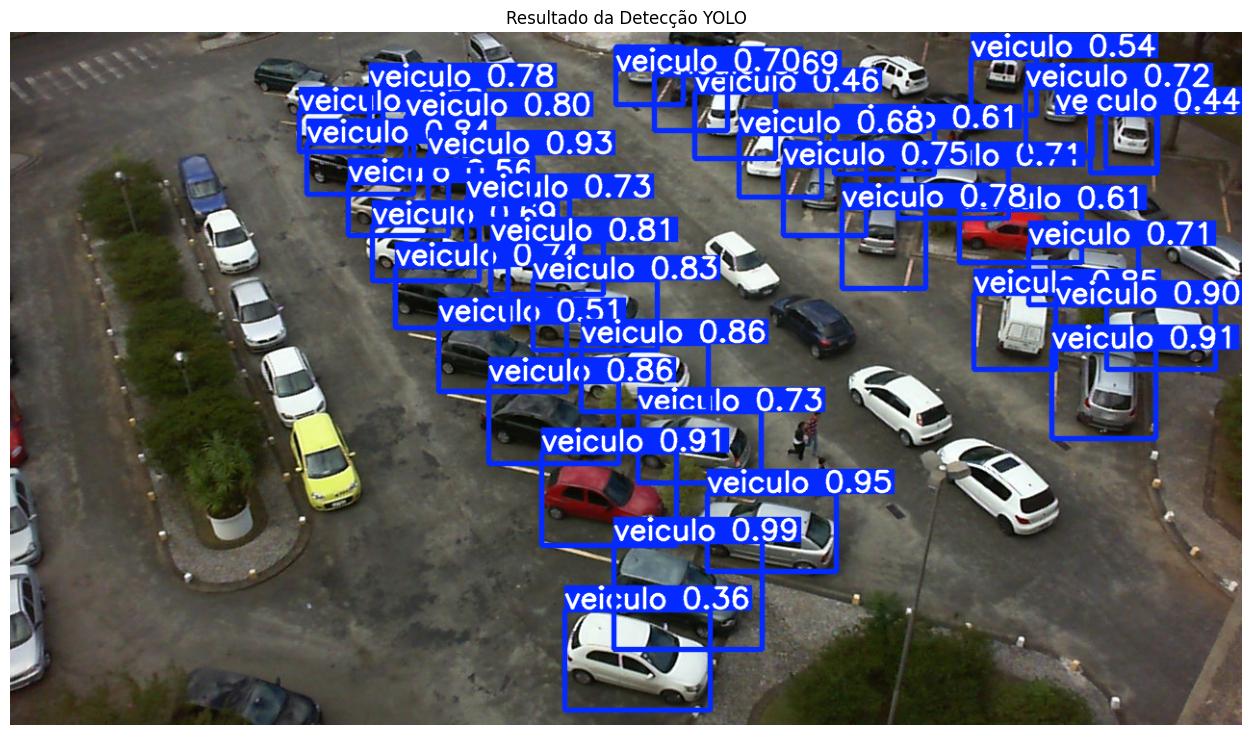

In [5]:

print(f"Carregando modelo {MODELO_YOLO}...")
# Carrega um modelo YOLO pré-treinado
modelo = YOLO(MODELO_YOLO)

print(f"Processando {CAMINHO_IMAGEM.name}...")
# Executa a detecção na imagem
resultado = modelo(CAMINHO_IMAGEM, verbose=False) # verbose=False para silenciar o log

# Mostra a imagem com as detecções
if resultado:
    # Obtem a imagem com as detecções (formato BGR)
    img_detectada_bgr = resultado[0].plot()
    
    # Converte de BGR para RGB (OpenCV -> Matplotlib)
    img_detectada_rgb = img_detectada_bgr[..., ::-1]

    # Mostrar a imagem inline no Jupyter
    plt.figure(figsize=(16, 9)) # Define um bom tamanho para a imagem
    plt.imshow(img_detectada_rgb)
    plt.axis('off') # Esconde os eixos X e Y
    plt.title("Resultado da Detecção YOLO")
    plt.show()
    

In [8]:

# Descrição dos comandos no topo superior esquerdo da imagem
NOME_JANELA = "Marcar Vagas - Pressione 's' para Salvar, 'u' para Desfazer, 'esc' para Sair"
COR_RASCUNHO = (0, 0, 255)  # Vermelho (BGR)
COR_VAGA_SALVA = (0, 255, 0) # Verde (BGR)
COR_TEXTO = (255, 255, 255) # Branco (BGR)

# Variáveis Globais para o Callback
vagas = []
drawing = False
x1_draw, y1_draw = 0, 0
img = None
orig = None

def desenhar_vaga(event, x, y, flags, param):
    # Callback do mouse para desenhar retângulos.
    global x1_draw, y1_draw, drawing, img

    if event == cv2.EVENT_LBUTTONDOWN:
        drawing = True
        x1_draw, y1_draw = x, y

    elif event == cv2.EVENT_MOUSEMOVE:
        if drawing:
            # Recria a imagem a partir da original + vagas salvas
            # para mostrar o rascunho sem sobrepor desenhos antigos
            img = orig.copy()
            for (x1, y1, x2, y2) in vagas:
                cv2.rectangle(img, (x1, y1), (x2, y2), COR_VAGA_SALVA, 2)
            
            # Desenha o rascunho
            cv2.rectangle(img, (x1_draw, y1_draw), (x, y), COR_RASCUNHO, 2)

    elif event == cv2.EVENT_LBUTTONUP:
        drawing = False
        x2_draw, y2_draw = x, y

        # Salva a vaga (garante que x1 < x2 e y1 < y2)
        vaga_coords = (
            min(x1_draw, x2_draw), 
            min(y1_draw, y2_draw), 
            max(x1_draw, x2_draw), 
            max(y1_draw, y2_draw)
        )
        vagas.append(vaga_coords)

        # Desenha o retângulo final (verde) na imagem principal
        cv2.rectangle(img, (vaga_coords[0], vaga_coords[1]), (vaga_coords[2], vaga_coords[3]), COR_VAGA_SALVA, 2)
        print(f"Vaga marcada: {vaga_coords}")

def desenhar_tudo():
    # Redesenha todas as vagas salvas (usado pelo 'Desfazer').
    global img
    img = orig.copy()
    for (x1, y1, x2, y2) in vagas:
        cv2.rectangle(img, (x1, y1), (x2, y2), COR_VAGA_SALVA, 2)

# Início do Script
img = cv2.imread(str(CAMINHO_IMAGEM))

if img is None:
    print(f"Erro: Não foi possível carregar a imagem em {CAMINHO_IMAGEM}")
else:
    orig = img.copy()
    cv2.namedWindow(NOME_JANELA)
    cv2.setMouseCallback(NOME_JANELA, desenhar_vaga)

    print("Arraste para marcar vaga. Pressione 's' para salvar, 'u' para desfazer, 'esc' para sair.")

    while True:
        # Cria uma cópia temporária para exibir o texto de ajuda
        img_com_texto = img.copy()
        
        # Adiciona o texto de ajuda na imagem
        cv2.putText(
            img_com_texto, 
            "'s' Salvar | 'u' Desfazer | 'esc' Sair", 
            (10, 30), # Posição (x, y)
            cv2.FONT_HERSHEY_SIMPLEX, 
            0.7, # Tamanho da fonte
            COR_TEXTO, 
            2 # Espessura
        )
        
        cv2.imshow(NOME_JANELA, img_com_texto)
        key = cv2.waitKey(1) & 0xFF

        # tecla S = Salvar
        if key == ord("s"):
            with open(CAMINHO_VAGAS_JSON, "w") as f:
                json.dump(vagas, f, indent=4)
            print(f"\nVagas salvas em {CAMINHO_VAGAS_JSON}")
            break

        # tecla U = Desfazer (Undo)
        elif key == ord("u"):
            if vagas:
                vaga_removida = vagas.pop()
                print(f"Vaga removida: {vaga_removida}")
                desenhar_tudo() # Redesenha a imagem sem a última vaga
            else:
                print("Nenhuma vaga para desfazer.")

        # tecla ESC = sair sem salvar
        elif key == 27:
            print("\nSaindo sem salvar.")
            break

    cv2.destroyAllWindows()
    

Arraste para marcar vaga. Pressione 's' para salvar, 'u' para desfazer, 'esc' para sair.
Vaga marcada: (589, 604, 719, 685)
Vaga marcada: (635, 529, 719, 621)
Vaga marcada: (566, 456, 671, 537)
Vaga marcada: (490, 381, 617, 432)
Vaga marcada: (443, 313, 553, 364)
Vaga marcada: (410, 254, 507, 293)
Vaga marcada: (370, 204, 466, 259)
Vaga marcada: (501, 219, 606, 259)
Vaga marcada: (542, 263, 653, 311)
Vaga marcada: (597, 326, 694, 384)
Vaga marcada: (943, 227, 996, 344)
Vaga marcada: (875, 171, 908, 229)
Vaga marcada: (828, 143, 859, 184)
Vaga marcada: (760, 97, 809, 174)
Vaga marcada: (470, 174, 569, 210)
Vaga marcada: (348, 150, 480, 195)
Vaga marcada: (310, 124, 389, 149)

Vagas salvas em Saida\Vagas\2013-04-10_15_20_10.JSON


In [8]:

try:
    with open(CAMINHO_VAGAS_JSON, "r") as f:
        vagas_lidas = json.load(f)
        print(f"Sucesso! {len(vagas_lidas)} vagas lidas de {CAMINHO_VAGAS_JSON}:")
        print(vagas_lidas)
except FileNotFoundError:
    print(f"Arquivo {CAMINHO_VAGAS_JSON} não encontrado.")
except Exception as e:
    print(f"Ocorreu um erro ao ler o arquivo: {e}")
    

Sucesso! 7 vagas lidas de Saida\Vagas\2012-09-11_16_43_43.JSON:
[[265, 193, 282, 226], [430, 191, 444, 240], [455, 314, 475, 347], [495, 308, 508, 352], [537, 317, 564, 352], [585, 310, 591, 354], [619, 310, 642, 360]]


Carregadas 17 vagas de Saida\Vagas\2013-04-10_15_20_10.JSON
Detectados 36 veículos.
Imagem de resultado salva em: Saida\Imagens\2013-04-10_15_20_10_status_vagas.jpg


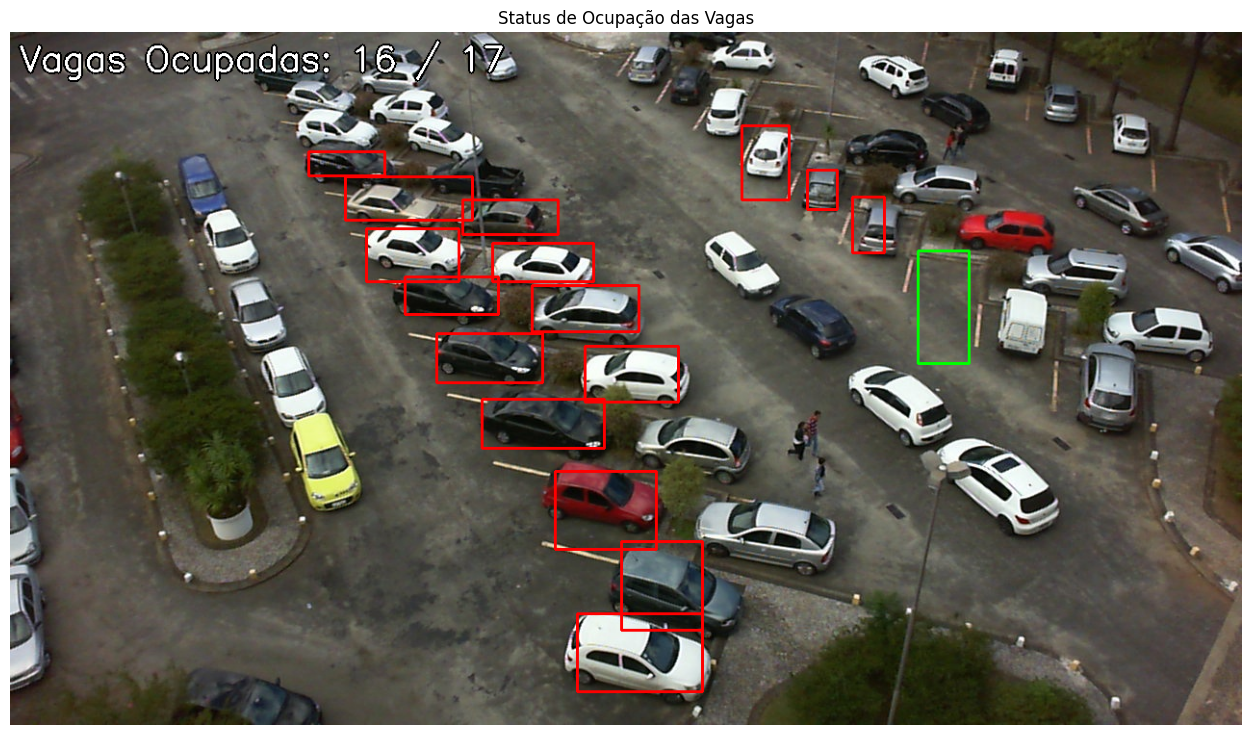

In [9]:


# Cores (em BGR)
COR_LIVRE = (0, 255, 0)   # Verde
COR_OCUPADA = (0, 0, 255) # Vermelho
COR_TEXTO = (255, 255, 255) # Branco

# Limite de Sobreposição (IoU): 
# Se um carro cobrir 20% da vaga, já conta como ocupada.
IOU_THRESHOLD = 0.2 

# FUNÇÃO DE INTERSEÇÃO (IoU) 
def calcular_iou(boxA, boxB):
    # Calcula a Interseção sobre União (IoU) entre duas caixas.
    # (x1, y1, x2, y2)
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # Área da interseção
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0:
        return 0

    # Área de cada caixa
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    # IoU = Interseção / União (Área Vaga + Área Carro - Interseção)
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


# Carregar a imagem original
img = cv2.imread(str(CAMINHO_IMAGEM))
if img is None:
    print(f"Erro: Não foi possível carregar a imagem em {CAMINHO_IMAGEM}")
    # Encerra aqui se a imagem falhar
else:
    # Carregar as vagas salvas
    try:
        with open(CAMINHO_VAGAS_JSON, "r") as f:
            vagas = json.load(f)
        print(f"Carregadas {len(vagas)} vagas de {CAMINHO_VAGAS_JSON}")
    except FileNotFoundError:
        print(f"Erro: Arquivo {CAMINHO_VAGAS_JSON} não encontrado. Execute a Célula 56 primeiro.")
        # Encerra aqui se o JSON falhar
    else:
        # Carregar o modelo YOLO
        modelo = YOLO(MODELO_YOLO)

        # Rodar a detecção na imagem
        resultados = modelo(img, verbose=False) # verbose=False para silenciar o log

        deteccoes = []
        # IDs de classe: 2=carro
        classes_veiculos = [0] 
        
        if resultados[0].boxes is not None:
            for box in resultados[0].boxes:
                if int(box.cls[0]) in classes_veiculos:
                    # Converte para inteiros
                    coords = box.xyxy[0].cpu().numpy().astype(int)
                    deteccoes.append(coords)
        
        print(f"Detectados {len(deteccoes)} veículos.")


        # VERIFICAR CADA VAGA 
        total_ocupadas = 0
        img_final = img.copy() # Cria cópia para desenhar

        for vaga in vagas:
            (x1_vaga, y1_vaga, x2_vaga, y2_vaga) = vaga
            status_vaga = "Livre"
            cor_final = COR_LIVRE

            for detec in deteccoes:
                iou = calcular_iou(vaga, detec)
                
                if iou > IOU_THRESHOLD:
                    status_vaga = "Ocupada"
                    cor_final = COR_OCUPADA
                    total_ocupadas += 1
                    break # Vaga ocupada, não precisa checar outros carros

            # Desenhar a vaga na imagem final
            cv2.rectangle(img_final, (x1_vaga, y1_vaga), (x2_vaga, y2_vaga), cor_final, 2)

        # MOSTRAR RESULTADO
        # Adicionar texto de resumo
        texto_status = f"Vagas Ocupadas: {total_ocupadas} / {len(vagas)}"
        cv2.putText(img_final, texto_status, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0,0,0), 6) # Sombra preta
        cv2.putText(img_final, texto_status, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1.2, COR_TEXTO, 2) # Texto branco

        # Salvar a imagem de resultado
        caminho_saida_img = pasta_saida / f"{CAMINHO_IMAGEM.stem}_status_vagas.jpg"
        cv2.imwrite(str(caminho_saida_img), img_final)
        print(f"Imagem de resultado salva em: {caminho_saida_img}")

        # Mostrar a imagem no notebook (convertendo BGR para RGB)
        img_rgb = cv2.cvtColor(img_final, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(16, 9))
        plt.imshow(img_rgb)
        plt.title("Status de Ocupação das Vagas")
        plt.axis('off')
        plt.show()
        

In [15]:
from ultralytics import YOLO

# 1. Carregue seu modelo treinado (ajuste o caminho se necessário)
model = YOLO("runs/detect/train/weights/best.pt")

# 2. Rode a validação (usa os dados da pasta 'val' que separamos)
metrics = model.val(data="data.yaml")

# 3. Exibir os resultados principais
print(f"Precisão (Box): {metrics.box.map:.4f}")      # mAP50-95 (Geral)
print(f"Precisão (Box 50): {metrics.box.map50:.4f}") # mAP50 (Mais tolerante)

Ultralytics 8.3.232  Python-3.13.7 torch-2.9.1+cpu CPU (Intel Core i5-9300H 2.40GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1607.2189.3 MB/s, size: 305.2 KB)
val: Scanning C:\Users\marce\Desktop\park-eye-project-final-final\datasets\park-eye\labels\val.cache... 13 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 13/13 9.9Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 1/1 1.1it/s 0.9s
                   all         13        428      0.804      0.774      0.828       0.43
Speed: 0.7ms preprocess, 51.8ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to C:\Users\marce\Desktop\park-eye-project-final-final\runs\detect\val
Precisão (Box): 0.4297
Precisão (Box 50): 0.8278


In [ ]:
import xml.etree.ElementTree as ET
import cv2
import numpy as np
from ultralytics import YOLO
from pathlib import Path
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# --- CONFIGURAÇÕES ---
PASTA_DATASET = Path("dataset_raw")  # Onde estão seus XMLs e JPGs originais
MODELO_PATH = "runs/detect/train/weights/best.pt"
IOU_THRESHOLD = 0.2  # Mesma sensibilidade do seu PoC

# Carregar Modelo
model = YOLO(MODELO_PATH)

y_real = []      # Gabarito (do XML)
y_sistema = []   # O que seu código decidiu

# Função de IoU (Exatamente a mesma do seu sistema principal)
def calcular_iou(boxA, boxB):
    # box = [x1, y1, x2, y2]
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    interArea = max(0, xB - xA) * max(0, yB - yA)
    if interArea == 0: return 0
    
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    
    return interArea / float(boxAArea + boxBArea - interArea)

print("Iniciando auditoria do sistema...")
arquivos = list(PASTA_DATASET.glob("*.xml"))

for xml_file in arquivos:
    # 1. Ler imagem e rodar YOLO
    jpg_file = xml_file.with_suffix(".jpg")
    if not jpg_file.exists(): continue
    
    img = cv2.imread(str(jpg_file))
    results = model(img, verbose=False)
    
    # Extrair caixas APENAS da classe 0 (Veículo)
    carros_detectados = []
    if results[0].boxes:
        for box in results[0].boxes:
            if int(box.cls[0]) == 0: # Filtro de segurança
                carros_detectados.append(box.xyxy[0].cpu().numpy())

    # 2. Ler as Vagas do XML (Gabarito)
    tree = ET.parse(xml_file)
    root = tree.getroot()
    
    for space in root.findall('space'):

    # 1) Validar atributo 'occupied'
    occupied_attr = space.get('occupied')
    if occupied_attr is None:
        print(f"[AVISO] Vaga sem atributo 'occupied' em {xml_file.name}. Ignorando.")
        continue

    status_real = int(occupied_attr)

    # 2) Validar contorno
    contour = space.find('contour')
    if contour is None:
        print(f"[AVISO] Contorno ausente em {xml_file.name}. Ignorando vaga.")
        continue

    pts_x = [int(p.get('x')) for p in contour.findall('point')]
    pts_y = [int(p.get('y')) for p in contour.findall('point')]

    if not pts_x or not pts_y:
        print(f"[AVISO] Contorno vazio em {xml_file.name}. Ignorando vaga.")
        continue

    # 3) Criar bounding box
    vaga_rect = [
        min(pts_x),
        min(pts_y),
        max(pts_x),
        max(pts_y)
    ]

    # 4) Calcular predição
    status_predito = 0
    for carro_box in carros_detectados:
        iou = calcular_iou(vaga_rect, carro_box)
        if iou > IOU_THRESHOLD:
            status_predito = 1
            break

    # 5) Somente aqui adicionamos REAL e PREDITO
    y_real.append(status_real)
    y_sistema.append(status_predito)



# --- RELATÓRIO FINAL ---
print("\n" + "="*40)
print("RELATÓRIO DE PERFORMANCE: SISTEMA PARK EYE")
print("="*40)
print(f"Total de Vagas Analisadas: {len(y_real)}")
print(f"Acurácia Global: {accuracy_score(y_real, y_sistema):.2%}")
print("\nDetalhamento por Classe:")
print(classification_report(y_real, y_sistema, target_names=['Livre (0)', 'Ocupada (1)']))

print("\nMatriz de Confusão:")
cm = confusion_matrix(y_real, y_sistema)
print(f"Verdadeiro Negativo (Acertou Livre): {cm[0][0]}")
print(f"Falso Positivo (Errou dizendo Ocupada): {cm[0][1]}")
print(f"Falso Negativo (Errou dizendo Livre): {cm[1][0]}  <-- PIOR ERRO")
print(f"Verdadeiro Positivo (Acertou Ocupada): {cm[1][1]}")

Iniciando auditoria do sistema...
[AVISO] Contorno vazio em 2012-12-29_18_30_42.xml. Ignorando vaga.
[AVISO] Contorno vazio em 2012-12-29_18_35_42.xml. Ignorando vaga.
[AVISO] Contorno vazio em 2012-12-29_18_40_42.xml. Ignorando vaga.
[AVISO] Contorno vazio em 2012-12-29_18_45_42.xml. Ignorando vaga.
[AVISO] Contorno vazio em 2012-12-29_19_25_43.xml. Ignorando vaga.
[AVISO] Contorno vazio em 2012-12-29_19_30_43.xml. Ignorando vaga.
[AVISO] Contorno vazio em 2012-12-29_19_35_43.xml. Ignorando vaga.

RELATÓRIO DE PERFORMANCE: SISTEMA PARK EYE
Total de Vagas Analisadas: 85


ValueError: Found input variables with inconsistent numbers of samples: [85, 78]